# Exploring NAB Datasets

In [1]:
import torch
from torch.utils.data import Dataset

import pandas as pd

In [2]:
def read_csv_with_datetime_index(data_path, datetime_column='timestamp'):
    _df = pd.read_csv(data_path)
    _df[datetime_column] = pd.to_datetime(_df[datetime_column])
    _df.set_index(datetime_column, inplace=True)
    return _df

# Exchange Datasets

Dataframe shape: (1624, 1)
                        value
timestamp                    
2011-07-01 00:00:01  0.081965
2011-07-01 01:00:01  0.098972
2011-07-01 02:00:01  0.065314
2011-07-01 03:00:01  0.070663
2011-07-01 04:00:01  0.102490


<Axes: xlabel='timestamp'>

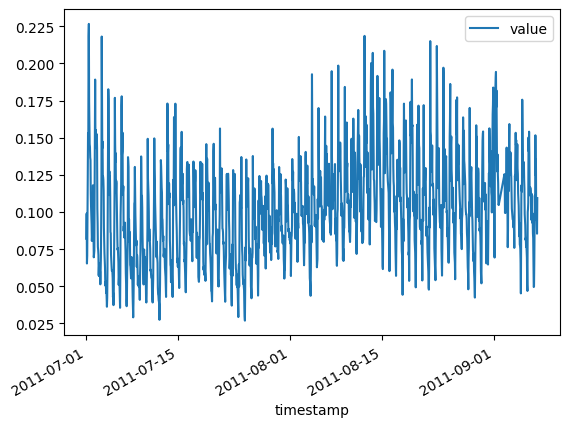

In [3]:
df_1 = read_csv_with_datetime_index('NAB/data/realAdExchange/exchange-2_cpc_results.csv')

print(f'Dataframe shape: {df_1.shape}')
print(df_1.head())
df_1.plot()

Dataframe shape: (1624, 1)
                        value
timestamp                    
2011-07-01 00:00:01  0.401048
2011-07-01 01:00:01  0.392719
2011-07-01 02:00:01  0.309996
2011-07-01 03:00:01  0.212939
2011-07-01 04:00:01  0.205801


<Axes: xlabel='timestamp'>

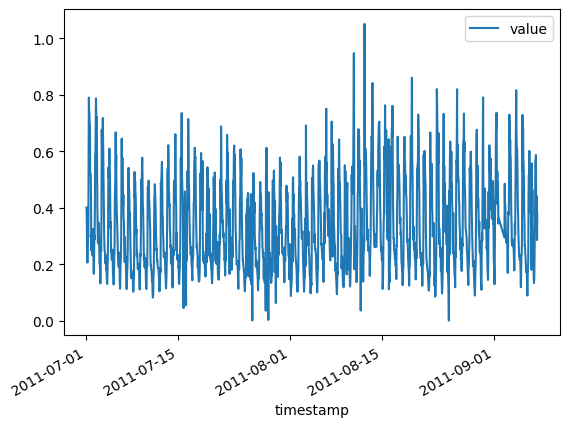

In [4]:
df_2 = read_csv_with_datetime_index('NAB/data/realAdExchange/exchange-2_cpm_results.csv')

print(f'Dataframe shape: {df_2.shape}')
print(df_2.head())
df_2.plot()

Dataframe shape: (1538, 1)
                        value
timestamp                    
2011-07-01 00:15:01  0.102709
2011-07-01 01:15:01  0.068039
2011-07-01 02:15:01  0.077994
2011-07-01 03:15:01  0.077682
2011-07-01 04:15:01  0.077966


<Axes: xlabel='timestamp'>

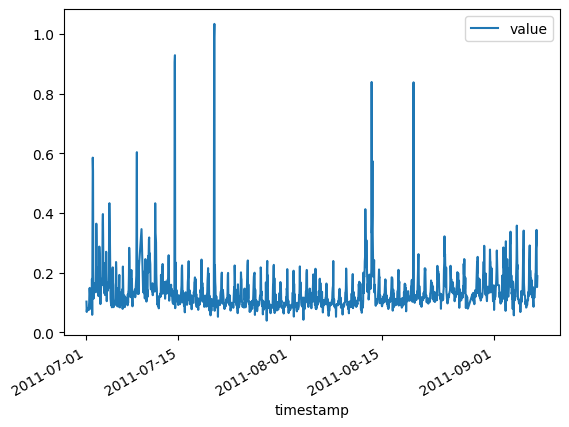

In [5]:
df_3 = read_csv_with_datetime_index('NAB/data/realAdExchange/exchange-3_cpc_results.csv')

print(f'Dataframe shape: {df_3.shape}')
print(df_3.head())
df_3.plot()

# Real Tweets Datasets

Dataframe shape: (15902, 1)
                     value
timestamp                 
2015-02-26 21:42:53    104
2015-02-26 21:47:53    100
2015-02-26 21:52:53     99
2015-02-26 21:57:53    154
2015-02-26 22:02:53    120


<Axes: xlabel='timestamp'>

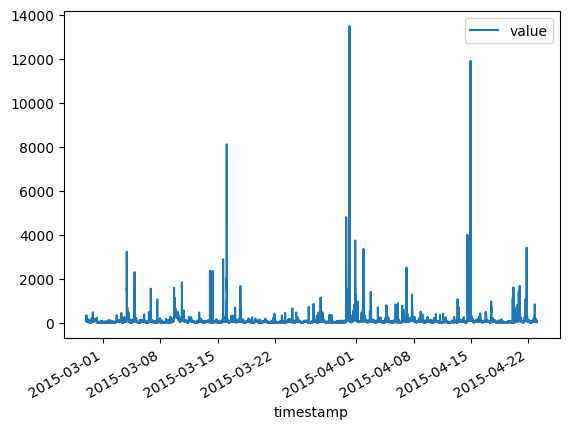

In [6]:
df_4 = read_csv_with_datetime_index('NAB/data/realTweets/Twitter_volume_AAPL.csv')

print(f'Dataframe shape: {df_4.shape}')
print(df_4.head())
df_4.plot()

Dataframe shape: (15831, 1)
                     value
timestamp                 
2015-02-26 21:42:53     57
2015-02-26 21:47:53     43
2015-02-26 21:52:53     55
2015-02-26 21:57:53     64
2015-02-26 22:02:53     93


<Axes: xlabel='timestamp'>

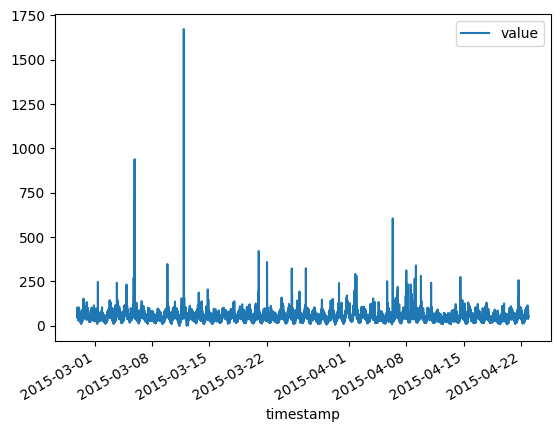

In [7]:
df_5 = read_csv_with_datetime_index('NAB/data/realTweets/Twitter_volume_AMZN.csv')

print(f'Dataframe shape: {df_5.shape}')
print(df_5.head())
df_5.plot()

# AWS Cloud Watch Datasets

Dataframe shape: (4032, 1)
                     value
timestamp                 
2014-02-14 14:30:00  0.132
2014-02-14 14:35:00  0.134
2014-02-14 14:40:00  0.134
2014-02-14 14:45:00  0.134
2014-02-14 14:50:00  0.134


<Axes: xlabel='timestamp'>

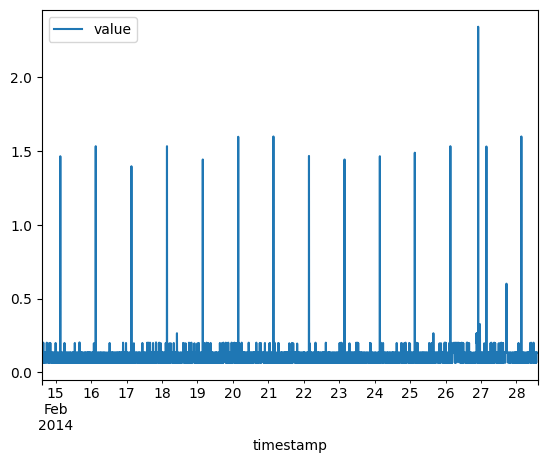

In [8]:
df_6 = read_csv_with_datetime_index('NAB/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv')

print(f'Dataframe shape: {df_6.shape}')
print(df_6.head())
df_6.plot()

Dataframe shape: (4032, 1)
                     value
timestamp                 
2014-02-14 14:30:00  1.732
2014-02-14 14:35:00  1.732
2014-02-14 14:40:00  1.960
2014-02-14 14:45:00  1.732
2014-02-14 14:50:00  1.706


<Axes: xlabel='timestamp'>

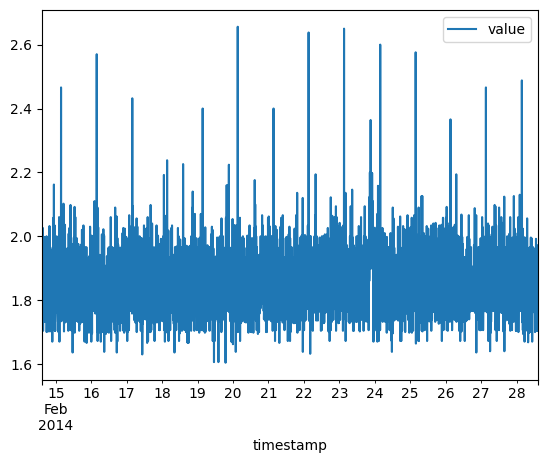

In [9]:
df_7 = read_csv_with_datetime_index('NAB/data/realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv')

print(f'Dataframe shape: {df_7.shape}')
print(df_7.head())
df_7.plot()

# Dataset Class

In [10]:
class MixtureTimeSeriesDataset(Dataset):
    def __init__(self, df_list, window_size,):
        """
        data_path_list: required to be a .csv file
        feature_columns and datetime_column: can be a single string (same for all datasets) or iterable strings (different per dataset).
        feature_columns should be 2D iterable of feature columns for each dataset. If a single string or iterable is given, it will be copied for all datasets
        datetime_column should be 1D iteralbe of datetime columns for each dataset. If a single string is given, it will be copied for all datasets
        """
        
        self.df_list = df_list
        self.window_size = window_size

        self.named_df_list = {}

        self.named_df_list = {f'expert_{i}': _df for i, _df in enumerate(self.df_list)}

    def __len__(self):
        len_list = [_df.shape[0] for _df in self.df_list]
        # take the longest as referance len
        number_of_samples = max(len_list)
        # make sure that last window fits
        return number_of_samples #- self.window_size

    def add_padding_maybe(self, _df_window):
        _df_window = _df_window.copy()
        if _df_window.shape[0] < self.window_size:
            num_rows_to_add = self.window_size - _df_window.shape[0]
            pad_date = pd.Timestamp('1970-01-01')
            pad_date_indexes = [pad_date] * num_rows_to_add
            df_zeros = pd.DataFrame(0.0, index=pad_date_indexes, columns=_df_window.columns)
            _df_window['attention_mask'] = 1.0
            df_zeros['attention_mask'] = 0.0
            df_padded = pd.concat([_df_window, df_zeros])
            return df_padded
        else:
            _df_window['attention_mask'] = 1.0
            return _df_window
        
    def __getitem__(self, start_idx):
        return_dict = {}

        for name, df_expert in self.named_df_list.items():
                    
            # get a NumPy array of size: (hyperparameters['window_size'], NUM_FEATURES)
            df_window = df_expert.iloc[start_idx:start_idx+self.window_size]
    
            # apend padding values (zeros) if necessery
            df_window = self.add_padding_maybe(df_window)
        
            # attention mask
            # 1 -> regular values, 0 -> pad values
            # (0s supposed to be masked)
            attention_mask = df_window['attention_mask'].copy()
            df_window.drop('attention_mask', axis=1, inplace=True)
            # (window_size, ) -> (lags/forecast,)
            attention_mask = attention_mask[:-1].values
            
            sample_window = df_window.values
            # input (lag) timestamps
            sample_timestamp_lags = df_window[:-1].index
            
            # divide window into lags and forecast (shifted by 1)
            # first window_size-1 steps
            lags = sample_window[:-1, :]
            # last window_size-1 steps
            forecast = sample_window[1:, :]
            
            # convert to tensor
            lags = torch.tensor(lags, dtype=torch.float32)
            forecast = torch.tensor(forecast, dtype=torch.float32)
            
            # (lags, date_input_features_size)
            # 1970-01-01 is used for padding values
            date = torch.tensor([sample_timestamp_lags.month, sample_timestamp_lags.day, sample_timestamp_lags.hour], dtype=torch.float32).permute(1, 0)

            # attention mask (tensor)
            attention_mask = torch.tensor(attention_mask, dtype=torch.float32)
            
            return_dict[name] = (lags, forecast, date, attention_mask)
        
        return return_dict

In [11]:
dataset_full = MixtureTimeSeriesDataset(
    df_list=[
        df_7,
        df_5
    ],
    window_size=120,
)
print(len(dataset_full))

dataset_full.named_df_list.keys()

15831


dict_keys(['expert_0', 'expert_1'])

In [12]:
df_7.index.min(), df_7.index.max()

(Timestamp('2014-02-14 14:30:00'), Timestamp('2014-02-28 14:25:00'))

In [13]:
_return_dict = dataset_full[4000]
_return_dict.keys()

dict_keys(['expert_0', 'expert_1'])

In [14]:
_lags, _forecast, _date, _attention_mask = _return_dict['expert_0']
_lags.shape, _forecast.shape, _date.shape, _attention_mask.shape

(torch.Size([119, 1]),
 torch.Size([119, 1]),
 torch.Size([119, 3]),
 torch.Size([119]))

In [15]:
_attention_mask

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])